In [453]:
%matplotlib notebook
import pandas as pd
import math
from collections import Counter
import random
import operator
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('adult.data')
df.columns.values[0] = 'age'
df.columns.values[1] = 'workclass'
df.columns.values[2] = 'fnlwgt'
df.columns.values[3] = 'education'
df.columns.values[4] = 'education_num'
df.columns.values[5] = 'marital_status'
df.columns.values[6] = 'occupation'
df.columns.values[7] = 'relationship'
df.columns.values[8] = 'race'
df.columns.values[9] = 'sex'
df.columns.values[10] = 'capital_gain'
df.columns.values[11] = 'capital_loss'
df.columns.values[12] = 'hours_per_week'
df.columns.values[13] = 'native_country'
df.columns.values[14] = 'target'

df = df.drop(columns=['fnlwgt'])
df = df.drop(columns=['capital_gain'])
df = df.drop(columns=['capital_loss'])
df = df[df.workclass != ' ?']
df = df[df.occupation != ' ?']
df = df[df.native_country != ' ?']
df.loc[df['native_country'] != ' United-States', 'native_country'] = 'Foreign-Country'
for i in range(0, max(df['age']), 5):
    df.loc[df['age'] == i + 1, 'age'] = i
    df.loc[df['age'] == i + 2, 'age'] = i
    df.loc[df['age'] == i + 3, 'age'] = i
    df.loc[df['age'] == i + 4, 'age'] = i
for i in range(0, max(df['hours_per_week']), 10):
    df.loc[df['hours_per_week'] == i + 1, 'hours_per_week'] = i
    df.loc[df['hours_per_week'] == i + 2, 'hours_per_week'] = i
    df.loc[df['hours_per_week'] == i + 3, 'hours_per_week'] = i
    df.loc[df['hours_per_week'] == i + 4, 'hours_per_week'] = i
    df.loc[df['hours_per_week'] == i + 5, 'hours_per_week'] = i
    df.loc[df['hours_per_week'] == i + 6, 'hours_per_week'] = i
    df.loc[df['hours_per_week'] == i + 7, 'hours_per_week'] = i
    df.loc[df['hours_per_week'] == i + 8, 'hours_per_week'] = i
    df.loc[df['hours_per_week'] == i + 9, 'hours_per_week'] = i

attributes = df.columns.tolist()
attributes.remove('target')
training_set, test_set = train_test_split(df, test_size=0.2)
training_set, validation_set = train_test_split(df, test_size=0.33)

# Learning tree

In [454]:
def attr_domain(attribute, examples):
    return examples[attribute].drop_duplicates()


class Node:
    def __init__(self, attribute):
        self.attribute = attribute
        self.branch = {}


def plurality_value(examples):  # returns most common target value
    c = Counter(examples.target).most_common(2)
    if c[1][0] == c[1][1]:
        return Node(c[0][random.randint(0, 1)])
    else:
        return Node(c[0][0])


def importance(attributes, examples):
    def bool_entropy(q):  # B(q)
        if q == 0 or q == 1:
            return 0
        return -(q * math.log(q, 2) + (1 - q) * math.log(1 - q, 2))

    def expected_entropy(attribute, examples):  # Remainder(A)
        sum = 0.0
        for k in attr_domain(attribute, examples):
            ek = examples[examples[attribute] == k]
            pk = len(ek[ek['target'] == ' >50K'])
            nk = len(ek[ek['target'] == ' <=50K'])
            q = float(pk) / float(pk + nk)
            sum += float(len(ek)) / len(examples) * bool_entropy(q)
        return sum

    gain_list = []  # list of Gain(A)
    for a in attributes:
        gain_list.append(
            bool_entropy(len(examples[examples['target'] == ' >50K']) / float(len(examples))) - expected_entropy(a,
                                                                                                                 examples))

    index, value = max(enumerate(gain_list), key=operator.itemgetter(1))
    return attributes[index]


def decision_tree_learning(examples, attributes, parent_examples=()):
    if len(examples) == 0:
        return plurality_value(parent_examples)
    elif len(set(examples.target)) == 1:  # if same classification
        return Node(examples.iat[0, len(examples.columns) - 1])
    elif len(attributes) == 0:
        return plurality_value(examples)
    else:
        A = importance(attributes, examples)
        tree = Node(A)
        a = list(attributes)
        a.remove(A)
        for v in attr_domain(A, examples):
            exs = examples[examples[A] == v]
            tree.branch[v] = decision_tree_learning(exs, a, examples)
        return tree

dtree = decision_tree_learning(training_set, attributes)

# Testing

In [455]:
def to_rules(tree):
    def visit(node, path):
        if len(node.branch) != 0:  # not leaf
            for branch in node.branch:
                path.append([node.attribute, branch])
                visit(node.branch[branch], path)
                path.pop()
        else:
            p = list(path)
            p.append(['target', node.attribute])
            rules.append(p)
    rules = []
    path = []
    visit(tree, path)
    return rules


def test_rules(dataset, rules):
    l = len(dataset)
    total_score = 0
    single_score = []
    for rule in rules:
        ds = dataset
        for r in rule[:-1]:
            ds = ds[ds[r[0]] == r[1]]
        r = rule[-1]
        hits = len(ds[ds['target'] == r[1]])
        total_score += hits
        if len(ds) == 0:
            single_score.append(0.5)
        else:
            single_score.append(float(hits) / len(ds))
        dataset = dataset.drop(ds.index.tolist(), axis=0)
    return float(total_score) / l, single_score


def test_dtree(dtree):
    rules = to_rules(dtree)
    ts, p = test_rules(test_set, rules)
    return ts

accuracy = test_dtree(dtree)
print('Score before pruning -> ', accuracy)

Score before pruning ->  0.8592739930382894


# Pruning

In [456]:
def rules_pruning(limit):
    def rule_lengths():
        l = []
        for rule in rules:
            l.append(len(rule))
        return l

    def errors(rule):
        vs = validation_set
        if rule is None or len(rule) <= 2:
            return 100000
        for r in rule[:-1]:
            vs = vs[vs[r[0]] == r[1]]
        r = rule[-1]
        e = len(vs[vs['target'] != r[1]])
        return e

    def score(rule):
        if len(rule) == 0:
            return 0
        vs = validation_set
        for r in rule[:-1]:
            vs = vs[vs[r[0]] == r[1]]
        total = len(vs)
        r = rule[-1]
        correct = len(vs[vs['target'] == r[1]])
        if total == 0:
            return 0
        return float(correct) / total

    def best_r(original_rule):  # sceglie la miglior r da togliere
        if len(original_rule) == 0:
            return False
        scores = []
        for r in original_rule[:-1]:
            rule = list(original_rule)
            rule.remove(r)
            scores.append(score(rule))
        return original_rule[(scores.index(max(scores)))]

    def change_rule_target(rule):
        if len(rule) == 0:
            return 0
        vs = validation_set
        for r in rule[:-1]:
            vs = vs[vs[r[0]] == r[1]]
        r = rule[-1]
        if len(vs) > 0:
            r[1] = Counter(vs.target).most_common()[0][0]
        return 0

    def is_in(smaller, bigger):  # Note: does not check last value
        if len(smaller) == 0 or len(bigger) == 0:
            return False
        for s in smaller[:-1]:
            match = False
            for b in bigger[:-1]:
                if s == b:
                    match = True
                    break
            if not match:
                return False
        return True

    def pruning(index):  # pruning of rules[index]
        if len(rules[index]) <= 2:
            return False
        original_rule = list(rules[index])
        r = best_r(rules[index])
        rules[index].remove(r)
        change_rule_target(rules[index])
        err_pruned = errors(rules[index])

        err_non_pruned = 0
        for rule in rules:
            if rules[index] != rule and is_in(rules[index], rule):
                err_non_pruned += errors(rule)
        err_non_pruned += errors(original_rule)
        if err_pruned >= err_non_pruned:  # turn back
            rules[index] = original_rule
            return False
        else:
            return True


    lengths = rule_lengths()
    while sum(lengths) != 0:
        max_l = max(lengths)
        if max_l <= limit:
            break
        for i in range(len(rules)):
            if lengths[i] == max_l:  # chooses only rules with length max_l
                p = pruning(i)
                if p:  # cleanup
                    lengths[i] -= 1
                    for l in range(len(rules)):
                        if is_in(rules[i], rules[l]) and i != l:
                            lengths[l] = 0
                            rules[l] = []
                else:
                    lengths[i] = 0
    for i in reversed(range(len(rules))):
        if len(rules[i]) == 0:
            rules.pop(i)

rules = to_rules(dtree)

# Results and graph comparison

In [457]:
import matplotlib
import matplotlib.pyplot as plt

accuracy_prun = []
x = []

for i in reversed(range(11)):
    rules_pruning(i)
    a, p = test_rules(test_set, rules)
    accuracy_prun.append(a)
    x.append(i)

<IPython.core.display.Javascript object>


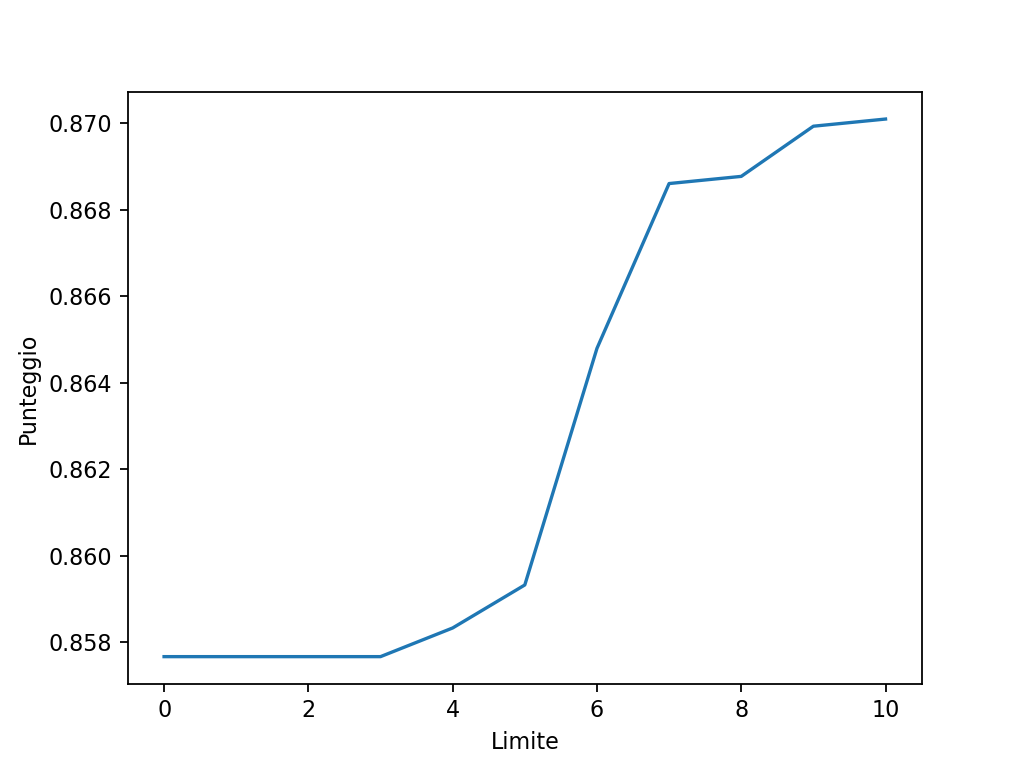

In [478]:
%matplotlib notebook
plt.xlabel('Limite')
plt.ylabel('Punteggio')
plt.plot(x, accuracy_prun, label = 'punteggio con pruning')
plt.show()